# Imports

In [1]:
import matplotlib

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    import os
    os.kill(os.getpid(), 9)
    # source: https://stackoverflow.com/a/60237923/2142093

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
time: 359 µs (started: 2023-02-15 22:36:40 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.27 s (started: 2023-02-15 22:36:42 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

# print('versión TF:', tf.__version__) # versión TF: 2.8.0
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

versión Keras: 2.11.0
time: 1.04 ms (started: 2023-02-15 22:36:48 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 25.5 s (started: 2023-02-15 22:36:51 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_8G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model = Modelo de Deep Learning
        -TYPE_IMG = regular o inverted
        -USE_DATA_AUG = sin_DA o con_DA
    '''

    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_'+ TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print('------ Model Saved -------')


time: 8.55 ms (started: 2023-02-15 22:37:20 +00:00)


# Imgs 64x64

- Test Accuracy: 0.8169063925743103
- Test Loss: 0.7995404005050659
- time: 56min 11s
- F1 score: 0.8171194223727858
- Precision score: 0.8301949651472088
- Recall:  0.8169063733784546
- Epoch: 50/50

## Cargar las imágenes

In [7]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 550 µs (started: 2023-02-15 22:37:23 +00:00)


In [8]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 15.6 s (started: 2023-02-15 22:37:24 +00:00)


In [9]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.4 ms (started: 2023-02-15 22:37:39 +00:00)


## Preparar el modelo

In [10]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 2s 0us/step
time: 9.87 s (started: 2023-02-15 22:37:39 +00:00)


In [11]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [12]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 88s 22ms/step - loss: 5.5438 - sparse_categorical_accuracy: 0.1088 - val_loss: 4.6946 - val_sparse_categorical_accuracy: 0.2375
Epoch 2/50
3325/3325 [==============================] - 66s 20ms/step - loss: 4.1361 - sparse_categorical_accuracy: 0.3406 - val_loss: 3.8098 - val_sparse_categorical_accuracy: 0.3845
Epoch 3/50
3325/3325 [==============================] - 66s 20ms/step - loss: 3.3771 - sparse_categorical_accuracy: 0.4784 - val_loss: 3.2396 - val_sparse_categorical_accuracy: 0.4713
Epoch 4/50
3325/3325 [==============================] - 67s 20ms/step - loss: 2.8566 - sparse_categorical_accuracy: 0.5645 - val_loss: 2.8249 - val_sparse_categorical_accuracy: 0.5413
Epoch 5/50
3325/3325 [==============================] - 66s 20ms/step - loss: 2.4746 - sparse_categorical_accuracy: 0.6229 - val_loss: 2.5191 - val_sparse_categorical_accuracy: 0.5832
Epoch 6/50
3325/3325 [==============================] - 66s 20ms/step - loss: 2.

In [13]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.93 s (started: 2023-02-15 23:34:03 +00:00)


In [14]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8169063925743103
- Test Loss: 0.7995404005050659
- time: 
- F1 score: 0.8171194223727858
- Precision score: 0.8301949651472088
- Recall:  0.8169063733784546
- Epoch: 
*********************************************************************************************************************************
time: 17.4 s (started: 2023-02-15 23:34:06 +00:00)


## Graficando

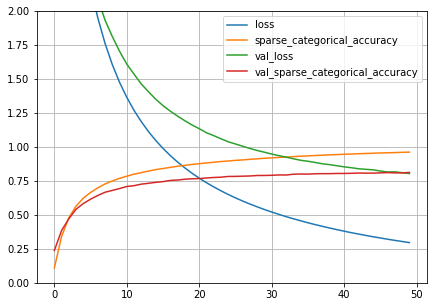

time: 261 ms (started: 2023-02-15 23:34:23 +00:00)


In [15]:
plot_loss(history)

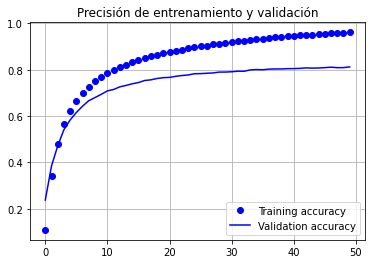

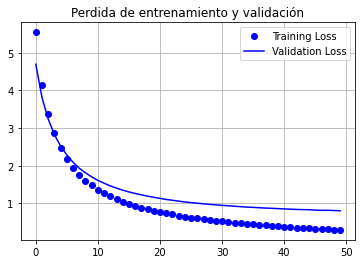

time: 552 ms (started: 2023-02-15 23:34:23 +00:00)


In [16]:
show_history(history)

In [17]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG)

------ Model Saved -------
time: 4.23 s (started: 2023-02-15 23:34:24 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8466582298278809
- Test Loss: 0.7029467225074768
- time: 55min 51s
- F1 score: 0.8468787292293439
- Precision score: 0.8577735582807005
- Recall:  0.8466582064297801
- Epoch: 50/50

## Cargar las imágenes

In [18]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 695 µs (started: 2023-02-15 23:34:28 +00:00)


In [19]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 19.5 s (started: 2023-02-15 23:34:28 +00:00)


In [20]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 1.14 ms (started: 2023-02-15 23:34:48 +00:00)


## Preparar el modelo

In [21]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.88 s (started: 2023-02-15 23:34:48 +00:00)


In [22]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['concatenate_1[0][0]']          
 D)                                                                                         

## Entrenar el modelo

In [23]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 76s 21ms/step - loss: 5.5266 - sparse_categorical_accuracy: 0.1185 - val_loss: 4.6992 - val_sparse_categorical_accuracy: 0.2409
Epoch 2/50
3325/3325 [==============================] - 68s 20ms/step - loss: 4.1566 - sparse_categorical_accuracy: 0.3526 - val_loss: 3.8447 - val_sparse_categorical_accuracy: 0.3954
Epoch 3/50
3325/3325 [==============================] - 67s 20ms/step - loss: 3.4317 - sparse_categorical_accuracy: 0.4874 - val_loss: 3.2908 - val_sparse_categorical_accuracy: 0.4892
Epoch 4/50
3325/3325 [==============================] - 67s 20ms/step - loss: 2.9310 - sparse_categorical_accuracy: 0.5729 - val_loss: 2.8924 - val_sparse_categorical_accuracy: 0.5502
Epoch 5/50
3325/3325 [==============================] - 67s 20ms/step - loss: 2.5582 - sparse_categorical_accuracy: 0.6316 - val_loss: 2.5890 - val_sparse_categorical_accuracy: 0.6003
Epoch 6/50
3325/3325 [==============================] - 67s 20ms/step - loss: 2.

In [24]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.37 s (started: 2023-02-16 00:30:44 +00:00)


In [25]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8466582298278809
- Test Loss: 0.7029467225074768
- time: 
- F1 score: 0.8468787292293439
- Precision score: 0.8577735582807005
- Recall:  0.8466582064297801
- Epoch: 
*********************************************************************************************************************************
time: 17.9 s (started: 2023-02-16 00:30:48 +00:00)


## Graficando

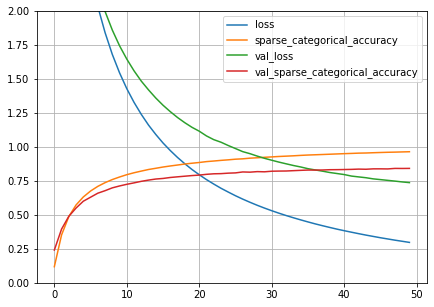

time: 202 ms (started: 2023-02-16 00:31:05 +00:00)


In [26]:
plot_loss(history)

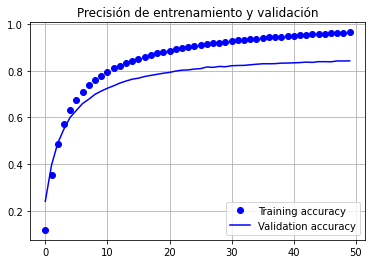

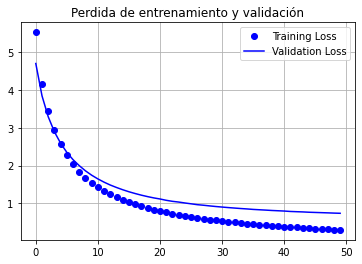

time: 359 ms (started: 2023-02-16 00:31:06 +00:00)


In [27]:
show_history(history)

In [28]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG)

------ Model Saved -------
time: 850 ms (started: 2023-02-16 00:31:06 +00:00)


# Imgs 112x112

- Test Accuracy: 0.8700648546218872
- Test Loss: 0.5811883807182312
- time: 58min 6s
- F1 score: 0.8704003458436315
- Precision score: 0.8790143438997489
- Recall:  0.8700648618161309
- Epoch: 50/50

## Cargar imágenes

In [29]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 627 µs (started: 2023-02-16 00:31:07 +00:00)


In [30]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24.3 s (started: 2023-02-16 00:31:07 +00:00)


In [31]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.2 ms (started: 2023-02-16 00:31:31 +00:00)


## Preparar el modelo

In [32]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.88 s (started: 2023-02-16 00:31:31 +00:00)


In [33]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 118, 118, 3)  0          ['concatenate_2[0][0]']    

## Entrenar el modelo

In [34]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 79s 22ms/step - loss: 5.2684 - sparse_categorical_accuracy: 0.1553 - val_loss: 4.3010 - val_sparse_categorical_accuracy: 0.3066
Epoch 2/50
3325/3325 [==============================] - 69s 21ms/step - loss: 3.7186 - sparse_categorical_accuracy: 0.4321 - val_loss: 3.3681 - val_sparse_categorical_accuracy: 0.4870
Epoch 3/50
3325/3325 [==============================] - 69s 21ms/step - loss: 2.9480 - sparse_categorical_accuracy: 0.5680 - val_loss: 2.8005 - val_sparse_categorical_accuracy: 0.5714
Epoch 4/50
3325/3325 [==============================] - 68s 21ms/step - loss: 2.4430 - sparse_categorical_accuracy: 0.6501 - val_loss: 2.4064 - val_sparse_categorical_accuracy: 0.6260
Epoch 5/50
3325/3325 [==============================] - 68s 21ms/step - loss: 2.0819 - sparse_categorical_accuracy: 0.7026 - val_loss: 2.1174 - val_sparse_categorical_accuracy: 0.6683
Epoch 6/50
3325/3325 [==============================] - 68s 21ms/step - loss: 1.

In [35]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.47 s (started: 2023-02-16 01:29:42 +00:00)


In [36]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8700648546218872
- Test Loss: 0.5811883807182312
- time: 
- F1 score: 0.8704003458436315
- Precision score: 0.8790143438997489
- Recall:  0.8700648618161309
- Epoch: 
*********************************************************************************************************************************
time: 18.4 s (started: 2023-02-16 01:29:47 +00:00)


## Graficando

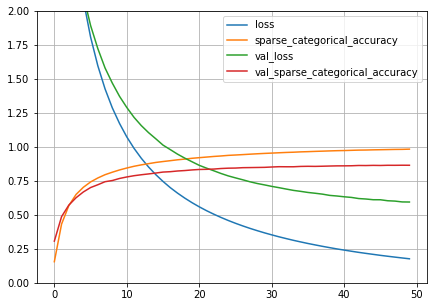

time: 192 ms (started: 2023-02-16 01:30:05 +00:00)


In [37]:
plot_loss(history)

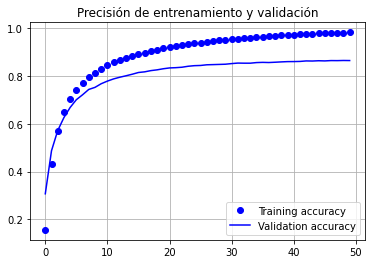

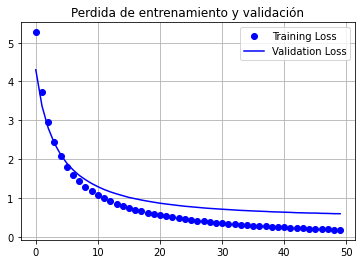

time: 364 ms (started: 2023-02-16 01:30:05 +00:00)


In [38]:
show_history(history)

In [39]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG)

------ Model Saved -------
time: 850 ms (started: 2023-02-16 01:30:06 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8859983086585999
- Test Loss: 0.5181868076324463
- time: 59min 33s
- F1 score: 0.8864717743056952
- Precision score: 0.8948877752081503
- Recall:  0.8859983079526227
- Epoch: 50/50

Se estancó en el 88% de accuracy

## Cargar las imágenes

In [40]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 557 µs (started: 2023-02-16 01:30:07 +00:00)


In [41]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 28.1 s (started: 2023-02-16 01:30:07 +00:00)


In [42]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.45 ms (started: 2023-02-16 01:30:35 +00:00)


## Preparar el modelo

In [43]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.9 s (started: 2023-02-16 01:30:35 +00:00)


In [44]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 133, 133, 3)  0          ['concatenate_3[0][0]']    

## Entrenar el modelo

In [45]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 80s 22ms/step - loss: 5.3223 - sparse_categorical_accuracy: 0.1563 - val_loss: 4.3613 - val_sparse_categorical_accuracy: 0.3158
Epoch 2/50
3325/3325 [==============================] - 70s 21ms/step - loss: 3.7640 - sparse_categorical_accuracy: 0.4463 - val_loss: 3.3951 - val_sparse_categorical_accuracy: 0.4987
Epoch 3/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.9737 - sparse_categorical_accuracy: 0.5853 - val_loss: 2.8096 - val_sparse_categorical_accuracy: 0.5909
Epoch 4/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.4561 - sparse_categorical_accuracy: 0.6654 - val_loss: 2.4048 - val_sparse_categorical_accuracy: 0.6463
Epoch 5/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.0884 - sparse_categorical_accuracy: 0.7149 - val_loss: 2.1072 - val_sparse_categorical_accuracy: 0.6877
Epoch 6/50
3325/3325 [==============================] - 71s 21ms/step - loss: 1.

In [46]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.6 s (started: 2023-02-16 02:30:13 +00:00)


In [47]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8859983086585999
- Test Loss: 0.5181868076324463
- time: 
- F1 score: 0.8864717743056952
- Precision score: 0.8948877752081503
- Recall:  0.8859983079526227
- Epoch: 
*********************************************************************************************************************************
time: 19 s (started: 2023-02-16 02:30:17 +00:00)


## Graficando


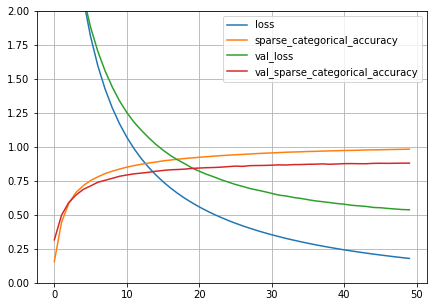

time: 194 ms (started: 2023-02-16 02:30:36 +00:00)


In [48]:
plot_loss(history)

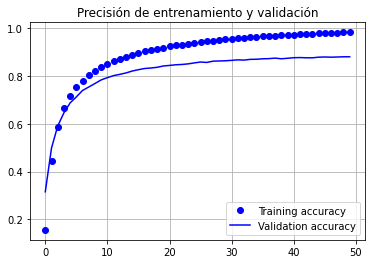

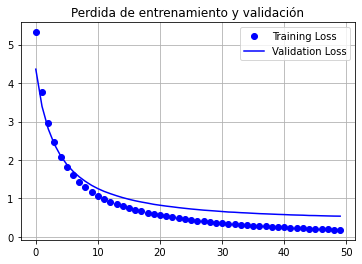

time: 364 ms (started: 2023-02-16 02:30:36 +00:00)


In [49]:
show_history(history)

In [50]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG)

------ Model Saved -------
time: 879 ms (started: 2023-02-16 02:30:37 +00:00)
